Import the necessary packages

In [1]:
using Lux
using NaNMath
using SciMLSensitivity
using DiffEqFlux
using DifferentialEquations
using Plots
using Zygote
using Random
rng = Random.seed!(1234)
using OptimizationOptimisers
using Statistics
using ComponentArrays
using CUDA
ArrayType = CUDA.functional() ? CuArray : Array
# Import our custom backend functions
include("coupling_functions/functions_example.jl")
include("coupling_functions/functions_NODE.jl")
include("coupling_functions/functions_loss.jl");

We are studying a phenomenon that can be described with the following ODE problem $$\dfrac{dP}{dt} = rP\left(1-\dfrac{P}{K}\right),$$ which is called the logistic equation. Given $P(t=0)=P_0$ we can solve this problem analytically to get $P(t) = \frac{K}{1+\left(K-P_0\right)/P_0 \cdot e^{-rt}}$. Let's plot the solution for $r=K=2, P_0=0.01$:

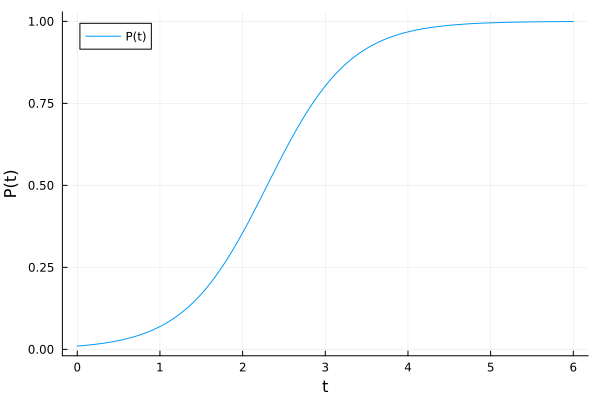

In [2]:
r=2
K=1
P0=0.01
function P(t)
    return K/(1+(K-P0)*exp(-r*t)/P0)
end
t = range(start=0, stop=6, step=0.01)
Pt = P.(t)
plot(t, Pt, label="P(t)", xlabel="t", ylabel="P(t)")

Now, let's say that we want to use the logistic equation to model an experiment like the activation energy of a neuron. We run the experiment and we observe the following:

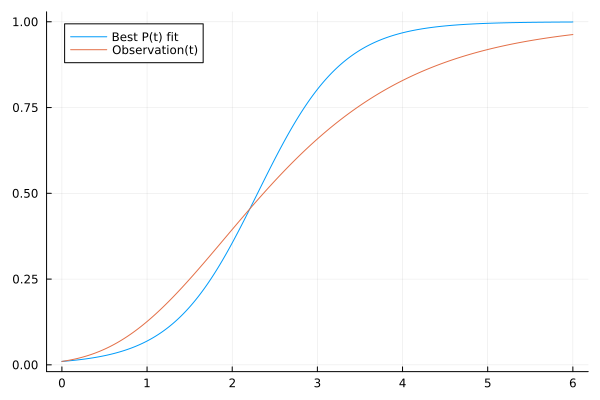

In [3]:
u_experiment = observation.()
plot(t, Pt, label="Best P(t) fit")
plot!(t, u_experiment[:], label="Observation(t)")

This means that our experimental system, despite its similarity, it is not described by a logistic ODE.
How can we then model our experiment as an ODE?

There are many simpler alternatives for this example (like Mode Decomposition, SINDY or Bayesian methods), but let's use this exercise to introduce a NODE:
\begin{equation}\dfrac{du}{dt} = \underbrace{ru\left(1-\dfrac{u}{K}\right)}_{f(u)} + NN(u|\theta).\end{equation}
In this NODE we are looking for a solution $u(t)$ that reproduces our observation.

We solve this simple 1d NODE using introducing the functionalities of this repository:

* We create the NN using `Lux`. In this example we do not discuss the structure of the NN, but we leave it as a black box that can be designed by the user. We will show later how to take inspiration from the physics of the problem to design optimal NN.

In [4]:
NN = create_nn()

SkipConnection(
    Dense(1 => 3),                      # 6 parameters
    #9
)         # Total: 6 parameters,
          #        plus 0 states.

* We define the force $f(u)$ compatibly with SciML.

In [5]:
f_u(u) = @. r*u*(1.0-u/K)

f_u (generic function with 1 method)

* We create the right hand side of the NODE, by combining the NN with f_u

In [6]:
f_NODE = create_f_NODE(NN, f_u; is_closed=true);

and get the parametrs that you want to train

In [7]:
θ, st = Lux.setup(rng, f_NODE);

* We define the NODE

In [8]:
trange = (0.0f0, 6.0f0)
u0 = [0.01]
full_NODE = NeuralODE(f_NODE, trange, Tsit5(), adaptive=false, dt=0.001, saveat=0.2);

we also solve it, using the zero-initialized parameters

In [9]:
untrained_NODE_solution = Array(full_NODE(u0, θ, st)[1]);

We now start training the model. The first thing we have to do is to design the **loss function**. For this example, we use *multishooting a posteriori* fitting (MulDtO), where we tell `Zygote` to compare `nintervals` of length `nunroll` to get the gradient. Notice that this method is differentiating through the solution of the NODE!

In [10]:
nunroll = 60
nintervals = 10
myloss = create_randloss_MulDtO(u_experiment, nunroll=nunroll, nintervals=nintervals);

We also define this auxiliary NODE that will be used for training

In [11]:
dt = 0.01 # it has to be as fine as the data
t_train_range = (0.0f0, dt*(nunroll+1)) # it has to be as long as unroll
training_NODE = NeuralODE(f_NODE, t_train_range, Tsit5(), adaptive=false, dt=dt, saveat=dt);

To initialize the training, we need some objects to monitor the procedure, and we trigger the first compilation.

In [12]:
lhist = Float32[];

Initialize and trigger the compilation of the model

In [13]:
pinit = ComponentArray(θ);
myloss(pinit);  # trigger compilation

Select the autodifferentiation type

In [14]:
adtype = Optimization.AutoZygote();

We transform the NeuralODE into an optimization problem

In [15]:
optf = Optimization.OptimizationFunction((x, p) -> myloss(x), adtype);
optprob = Optimization.OptimizationProblem(optf, pinit);

Select the training algorithm:
we choose Adam with learning rate 0.1, with gradient clipping

In [16]:
ClipAdam = OptimiserChain(Adam(1.0f-1), ClipGrad(1));

Finally we can train the NODE

In [17]:
result_neuralode = Optimization.solve(optprob,
    ClipAdam;
    # Commented out the line that uses a custom callback to track loss over time
    ##callback = callback,
    maxiters = 100
    )
pinit = result_neuralode.u;
optprob = Optimization.OptimizationProblem(optf, pinit);

(Notice that the block above can be repeated to continue training)

Those are the results that we get

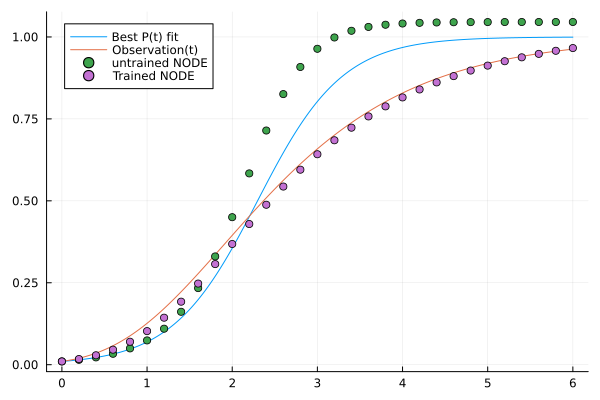

In [18]:
plot()
plot(t, Pt, label="Best P(t) fit")
plot!(t, u_experiment[:], label="Observation(t)")
scatter!(range(start=0, stop=6, step=0.2), untrained_NODE_solution[:], label="untrained NODE", marker=:circle)
scatter!(range(start=0, stop=6, step=0.2), Array(full_NODE([u_experiment[1]], result_neuralode.u, st)[1])[:], label="Trained NODE", marker=:circle)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*